In [1]:
import keras
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, Conv2D, Flatten, BatchNormalization, Add, MaxPooling2D, AveragePooling2D, Dropout
import keras.backend as K
from keras.models import Model
from keras import regularizers
import sys
import random
from keras.utils import np_utils
sys.version

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarn

'3.5.2 (default, Oct  8 2019, 13:06:37) \n[GCC 5.4.0 20160609]'

# 构造恒等块

In [2]:
def identity_block(X, f, filters):
    '''
    X:输入向量，Tensor类型
    f:conv卷积核的维度
    filter:定义主路径上卷积核的个数
    '''
    F1, F2, F3 = filters
    X_shortcut = X
    #第一个卷积块
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer='glorot_uniform')(X)
    #归一化
    X = BatchNormalization(axis = 3)(X)
    #激活层
    X = Activation(activation='relu')(X)
    
    #第二个卷积块
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer='glorot_uniform')(X)
    #归一化
    X = BatchNormalization(axis=3)(X)
    #激活层
    X = Activation(activation='relu')(X)
    
    #第三个卷积块
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer='glorot_uniform')(X)
      #归一化
    X = BatchNormalization(axis=3)(X)
    
    #两条路径合并
    X = Add()([X, X_shortcut])
    #激活层
    X = Activation(activation='relu')(X)
    
    return X

#  构造卷积块

In [3]:
def conv_block(X, f, filters, s=2):
    '''
    X：输入向量
    f:卷积核的维度
    filters:各个组成块的卷积核的个数
    s:做卷积时的步伐
    '''
    F1, F2, F3 = filters
    #捷径
    X_shortcut = X
    #主路径
    #主路径的第一个卷积块
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation(activation='relu')(X)
    
    #主路径上的第二个卷积块
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation(activation='relu')(X)
    
    #主路径上的第三个卷积块
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3)(X)
    
    #捷径
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    
    #主路径捷径合并
    X = Add()([X, X_shortcut])
    X = Activation(activation='relu')(X)
    
    return X

# 构建残差网络

In [4]:
def ResNet(input_shape):
    '''
    input_shape:输入的Tensor维度
    
    '''
    X_input = Input(input_shape)
    #对输入数据进行零填充，padding=(3, 3)
    X = ZeroPadding2D(padding=(3, 3))(X_input)
    
    #state1
    '''
    卷积层有64个过滤器，其维度为（7，7），步伐为（2，2），命名为“conv1”

    规范层（BatchNorm）对输入数据进行通道轴归一化。

    最大值池化层使用一个（3，3）的窗口和（2，2）的步伐
    '''
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='valid', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3)(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)
    
    #state2
    '''

    卷积块使用f=3个大小为[64，64，256]的过滤器，f=3，s=1

    2个恒等块使用三个大小为[64，64，256]的过滤器，f=3

    '''
    X = conv_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256])
    X = identity_block(X, f=3, filters=[64, 64, 256])
    
    #state3
    '''

    卷积块使用f=3个大小为[128,128,512]的过滤器，f=3，s=2

    3个恒等块使用三个大小为[128,128,512]的过滤器，f=3

    '''
    X = conv_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    
    #state4
    '''
    卷积块使用f=3个大小为[256,256,1024]的过滤器，f=3，s=2

    5个恒等块使用三个大小为[256,256,1024]的过滤器，f=3
    
    '''
    X = conv_block(X, f=3, filters=[256, 256, 1024], s=2)
    
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    
    #state5
    '''
    卷积块使用f=3个大小为[512,512,2048]的过滤器，f=3，s=2

    2个恒等块使用三个大小为[256,256,2048]的过滤器，f=3
    '''
    X = conv_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, f=3, filters=[256, 256, 2048])
    X = identity_block(X, f=3, filters=[256, 256, 2048])
    
    #均值池化层
    '''
    均值池化层使用维度为（2,2）的窗口
    '''
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    #平滑
    X = Flatten()(X)
    
    '''
    全连接层
    使用softmax作为激活函数，输出为2,代表分类成两类的概率
    '''
    #将 softmax调换成sigmod 更适合二分类
    X = Dense(7, activation='softmax', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(2.0), activity_regularizer=regularizers.l1(2.0))(X)
    model = Model(inputs=X_input, outputs=X)
    
    return model

# 建立模型实例并编译

In [5]:
model = ResNet((60, 264, 1))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## 导入数据

In [6]:
import os
from scipy.io import loadmat
import numpy as np

In [7]:
path = r'/home/ubuntu/音频处理trainCqcc/'
list_root = os.listdir(path)

list_root

['ofile_time_stretch',
 'US_1',
 'SS_2',
 'VC_1',
 'SS_1',
 'bonafide',
 'VC_4',
 'SS_4',
 'ofile_time_roll']

In [8]:
Label = []
Data =[]
Label_dic = {'bonafide':0}
for path_children in list_root:
    if path_children =='ofile_time_roll' or path_children =='ofile_time_stretch' :#or path_children =='SS_4':
        continue
    if path_children in Label_dic:
        judge = Label_dic[path_children]
    else:
        judge = len(Label_dic)
        Label_dic[path_children] = judge

    path_children_ = path+path_children
    list_children = os.listdir(path_children_)
    dict_kind = {}
    
    if path_children not in dict_kind:
        dict_kind[path_children]=0
        
        
    seq = [i for i in range(len(list_children))]
    choice  = random.sample(seq,2000)
    choice.sort()
    for number,mats in enumerate(list_children):
        if number not in choice:
            continue
        dict_kind[path_children]+=1
#         if dict_kind[path_children]>2000  and path_children !='bonafide' and path_children !='ofile_time_roll' and  path_children!='ofile_time_stretch':
#             break
#         elif dict_kind[path_children]>2000:
#             break
        Label.append(judge)
        m = loadmat(path_children_+'/'+mats)
        Data.append(m['CQcc'].reshape(60,264,1))

In [10]:
Data = np.array(Data)
Label = np.array(Label)
print(Label_dic)
print(Data.shape)
print(Label.shape)

(14000, 60, 264, 1)

# 独热编码

In [12]:
y_train = np_utils.to_categorical(Label,num_classes= 7)
print(y_train[::1000])
print(y_train.shape)

from sklearn.utils import shuffle
Data,y_train = shuffle(Data,y_train)

callbacks = [
    EarlyStopping(monitor='val_acc',patience=20),
    ModelCheckpoint('多分类.h5',monitor='val_acc',save_best_only=True,verbose=1),
    ]

[[0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.

In [15]:
train_history = model.fit(Data, y_train, epochs=8, batch_size=70, validation_split=0.2,callbacks=callbacks)

Train on 11200 samples, validate on 2800 samples
Epoch 1/8
11200/11200 [==============================] - 133s 12ms/step - loss: 143.5882 - acc: 0.7771 - val_loss: 141.5123 - val_acc: 0.7486

Epoch 00001: val_acc improved from -inf to 0.74857, saving model to 多分类.h5
Epoch 2/8
11200/11200 [==============================] - 126s 11ms/step - loss: 140.2445 - acc: 0.9527 - val_loss: 147.0650 - val_acc: 0.3968

Epoch 00002: val_acc did not improve
Epoch 3/8
11200/11200 [==============================] - 126s 11ms/step - loss: 140.1699 - acc: 0.9819 - val_loss: 141.2391 - val_acc: 0.7350

Epoch 00003: val_acc did not improve
Epoch 4/8
11200/11200 [==============================] - 126s 11ms/step - loss: 140.1337 - acc: 0.9814 - val_loss: 140.7040 - val_acc: 0.8296

Epoch 00004: val_acc improved from 0.74857 to 0.82964, saving model to 多分类.h5
Epoch 5/8
11200/11200 [==============================] - 126s 11ms/step - loss: 140.3269 - acc: 0.9664 - val_loss: 142.3656 - val_acc: 0.6225

Epoch 000

In [18]:
# define the function
def training_vis(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    ax2.plot(acc,label='train_acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy  on Training and Validation Data')
    ax2.legend()
    plt.tight_layout()

training_vis(train_history)

In [2]:
model = keras.models.load_model("多分类.h5")

# dev开发集

In [161]:
path = r'/home/ubuntu/音频处理devCqcc/'
list_root = os.listdir(path)

list_root

In [163]:
Label = []
Data =[]
Label_dic = {'bonafide':0}
for path_children in list_root:
    if path_children =='ofile_time_roll' or path_children =='ofile_time_stretch' :#or path_children =='SS_4':
        continue
    if path_children in Label_dic:
        judge = Label_dic[path_children]
    else:
        judge = len(Label_dic)
        Label_dic[path_children] = judge

    path_children_ = path+path_children
    list_children = os.listdir(path_children_)
    dict_kind = {}
    
    if path_children not in dict_kind:
        dict_kind[path_children]=0
        
        
    seq = [i for i in range(len(list_children))]
    choice  = random.sample(seq,100)
    choice.sort()
    for number,mats in enumerate(list_children):
        if number not in choice:
            continue
        dict_kind[path_children]+=1
        Label.append(judge)
        m = loadmat(path_children_+'/'+mats)
        Data.append(m['CQcc'].reshape(60,264,1))

In [ ]:
Data = np.array(Data)
Label = np.array(Label)
print(Label_dic)
print(Data.shape)
print(Label.shape)

In [167]:
def transport(y):
    test_y = []
    for i in  y:
        max = np.argmax(i)
        if max == 0:
            test_y.append(max)
        else:
            test_y.append(1)
    return test_y

def transport1(y):
    test_y = []
    for i in  y:
        max = np.argmax(i)
        test_y.append(max)
    return test_y

def label_transport(label):
    test_y = []
    for i in  label:
        if i==0:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y

x_pre = model.predict(Data)

y_pre = transport(x_pre)
y_pre1 = transport1(x_pre)
y_true = label_transport(Label)

<Figure size 432x468 with 0 Axes>

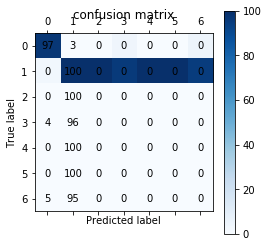

<Figure size 432x468 with 0 Axes>

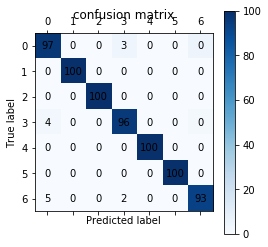

In [168]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def cm_plot(original_label, predict_label, pic=None):
    cm = confusion_matrix(original_label, predict_label)   # 由原标签和预测标签生成混淆矩阵
    plt.figure(figsize=(6,6.5))
    plt.matshow(cm, cmap=plt.cm.Blues)     # 画混淆矩阵，配色风格使用cm.Blues
    plt.colorbar()    # 颜色标签
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
            # annotate主要在图形中添加注释
            # 第一个参数添加注释
            # 第二个参数是注释的内容
            # xy设置箭头尖的坐标
            # horizontalalignment水平对齐
            # verticalalignment垂直对齐
            # 其余常用参数如下：
            # xytext设置注释内容显示的起始位置
            # arrowprops 用来设置箭头
            # facecolor 设置箭头的颜色
            # headlength 箭头的头的长度
            # headwidth 箭头的宽度
            # width 箭身的宽度
    plt.ylabel('True label')  # 坐标轴标签
    plt.xlabel('Predicted label')  # 坐标轴标签
    plt.title('confusion matrix')
    if pic is not None:
        plt.savefig(str(pic) + '.jpg')
    plt.show()


cm_plot(y_pre,Label)

cm_plot(y_pre1,Label)

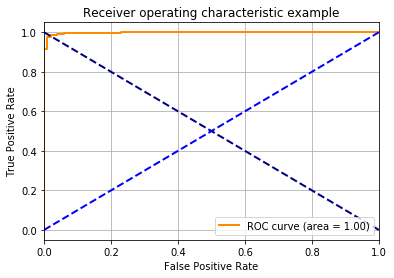

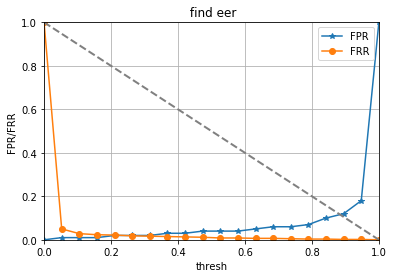

<Figure size 432x468 with 0 Axes>

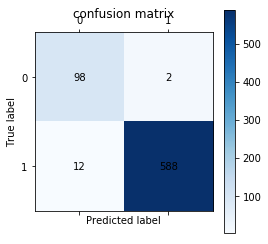

判定阈值： 0.23684210526315785  准确率 0.02


In [169]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,accuracy_score
from sklearn.metrics import precision_score,f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



# 为每个类别计算ROC曲线和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(y_true, 1-x_pre[:, 0])
    roc_auc[i] = auc(fpr[i], tpr[i])
# fpr[0].shape==tpr[0].shape==(21, ), fpr[1].shape==tpr[1].shape==(35, ), fpr[2].shape==tpr[2].shape==(33, ) 
# roc_auc {0: 0.9118165784832452, 1: 0.6029629629629629, 2: 0.7859477124183007}

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.grid(b=True) # 显示网格线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


# EER计算
def findX(X1, X2, T):
    #求一下两条线的交点, 默认X1递增， X2递减
    # 先找到4个点满足X11 < X21, X12 > X22 
    iT = -1
    iX = -1
    for idx, x in enumerate(X1):
        if X2[idx] > X1[idx]:
            continue
        else:
            # 找到第一个X2<X1的点
            X11 = X1[idx - 1]
            X12 = X1[idx]
            X21 = X2[idx-1]
            X22 = X2[idx]
            T1 = T[idx-1]
            T2 = T[idx]
            #由三角形相似性求
            iT = (T2-T1) * (X21-X11) / (X12 + X21 - X22 - X11) + T1
            iX = X11 + (iT - T1)/ (T2- T1) * (X12 - X11)
            break
    return iT, iX
            

def getEER(ol, pl):
    cm = confusion_matrix(ol, pl)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    FPR = FP / (TN + FP)
    FRR = FN / (TP + FN)
    return FPR, FRR

def transport(y):
    test_y = []
    for i in  y:
        max = np.argmax(i)
        if max == 0:
            test_y.append(max)
        else:
            test_y.append(1)
    return test_y

def transport1eval(y, yu=0.9):
    test_y = []
    for i in  y:
        if i[0]>yu:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y

def label_transport(label):
    test_y = []
    for i in  label:
        if i==0:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y

def drawEER(yus, FPRs, FRRs):
    iT, iX = findX(FPRs, FRRs, yus)
    plt.figure()
    plt.plot(yus,FPRs,marker = '*',label = 'FPR')
    plt.plot(yus, FRRs, marker = 'o',label = 'FRR')
    plt.legend()
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('thresh')
    plt.ylabel('FPR/FRR')
    plt.title(' find eer')
    plt.grid(b=True) # 显示网格线
    plt.plot([0, 1], [1, 0], color='grey', lw=lw, linestyle='--')
#     plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
    plt.show()

    return iT, iX 

def allAboutEER(y_true, x_pre, threshs):
    # 这里y_true, x_pre顺序改回来了。。。
    '''
    threshs: 阈值的list
    '''
    FPRs = []
    FRRs = []
    for thresh in threshs:
        y_pre1 = transport1eval(x_pre, thresh)
        FPR, FRR = getEER(y_true, y_pre1)
        FPRs.append(FPR)
        FRRs.append(FRR)
    iT, iX  =drawEER(threshs, FPRs, FRRs)
    return iT, iX 
    

testyus = np.linspace(0,1,20)
# 阈值列表
threshs = list(testyus)




y_pre = transport(x_pre)
y_pre1 = transport1eval(x_pre, 0.88)
y_true = label_transport(Label)


iT, iX  = allAboutEER(y_true,x_pre,threshs)

# y_pre = transport(x_pre)
y_pre1 = transport1eval(x_pre,iT)
y_true = label_transport(Label)

# cm_plot(y_pre,y_true)
cm_plot(y_pre1,y_true)
print('判定阈值：',iT,' 准确率', iX)

# 评估集！！！

In [109]:
path = r'/home/ubuntu/音频处理evalCqcc/'
list_root = os.listdir(path)

list_root

['A16',
 'A14',
 'A11',
 'A13',
 'A12',
 'A07',
 'A08',
 'bonafide',
 'A19',
 'A17',
 'A15',
 'A18',
 'A09',
 'A10']

In [110]:
Label = []
Data =[]
Label_dic = {'bonafide':0}
for path_children in list_root:
    if path_children =='ofile_time_roll' or path_children =='ofile_time_stretch':
        continue
    if path_children in Label_dic:
        judge = Label_dic[path_children]
    else:
        judge = len(Label_dic)
        Label_dic[path_children] = judge

    path_children_ = path+path_children
    list_children = os.listdir(path_children_)
    dict_kind = {}
    
    if path_children not in dict_kind:
        dict_kind[path_children]=0
        
    for mats in list_children:
        dict_kind[path_children]+=1
#         if dict_kind[path_children]>2000  and path_children !='bonafide' and path_children !='ofile_time_roll' and  path_children!='ofile_time_stretch':
#             break
        if dict_kind[path_children]>550 and path_children != 'bonafide':
            break
        Label.append(judge)
        m = loadmat(path_children_+'/'+mats)
        Data.append(m['CQcc'].reshape(60,264,1))

In [112]:
Data = np.array(Data)
Label = np.array(Label)
print(Data.shape)
print(Label.shape)

(14505, 60, 264, 1)
(14505,)


In [147]:
x_pre = model.predict(Data)

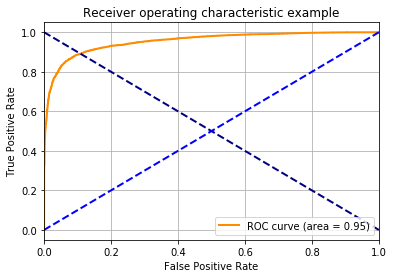

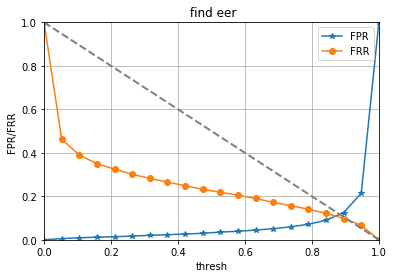

<Figure size 432x468 with 0 Axes>

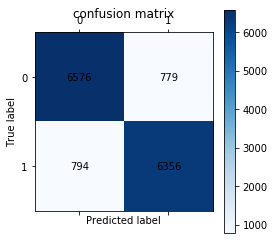

判定阈值： 0.8706257363215429  准确率 0.1087942477876106


In [157]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,accuracy_score
from sklearn.metrics import precision_score,f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



# 为每个类别计算ROC曲线和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(y_true, 1-x_pre[:, 0])
    roc_auc[i] = auc(fpr[i], tpr[i])
# fpr[0].shape==tpr[0].shape==(21, ), fpr[1].shape==tpr[1].shape==(35, ), fpr[2].shape==tpr[2].shape==(33, ) 
# roc_auc {0: 0.9118165784832452, 1: 0.6029629629629629, 2: 0.7859477124183007}

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.grid(b=True) # 显示网格线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


# EER计算
def findX(X1, X2, T):
    #求一下两条线的交点, 默认X1递增， X2递减
    # 先找到4个点满足X11 < X21, X12 > X22 
    iT = -1
    iX = -1
    for idx, x in enumerate(X1):
        if X2[idx] > X1[idx]:
            continue
        else:
            # 找到第一个X2<X1的点
            X11 = X1[idx - 1]
            X12 = X1[idx]
            X21 = X2[idx-1]
            X22 = X2[idx]
            T1 = T[idx-1]
            T2 = T[idx]
            #由三角形相似性求
            iT = (T2-T1) * (X21-X11) / (X12 + X21 - X22 - X11) + T1
            iX = X11 + (iT - T1)/ (T2- T1) * (X12 - X11)
            break
    return iT, iX
            

def getEER(ol, pl):
    cm = confusion_matrix(ol, pl)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    FPR = FP / (TN + FP)
    FRR = FN / (TP + FN)
    return FPR, FRR

def transport(y):
    test_y = []
    for i in  y:
        max = np.argmax(i)
        if max == 0:
            test_y.append(max)
        else:
            test_y.append(1)
    return test_y

def transport1eval(y, yu=0.9):
    test_y = []
    for i in  y:
        if i[0]>yu:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y

def label_transport(label):
    test_y = []
    for i in  label:
        if i==0:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y

def drawEER(yus, FPRs, FRRs):
    iT, iX = findX(FPRs, FRRs, yus)
    plt.figure()
    plt.plot(yus,FPRs,marker = '*',label = 'FPR')
    plt.plot(yus, FRRs, marker = 'o',label = 'FRR')
    plt.legend()
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('thresh')
    plt.ylabel('FPR/FRR')
    plt.title(' find eer')
    plt.grid(b=True) # 显示网格线
    plt.plot([0, 1], [1, 0], color='grey', lw=lw, linestyle='--')
#     plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
    plt.show()

    return iT, iX 

def allAboutEER(y_true, x_pre, threshs):
    # 这里y_true, x_pre顺序改回来了。。。
    '''
    threshs: 阈值的list
    '''
    FPRs = []
    FRRs = []
    for thresh in threshs:
        y_pre1 = transport1eval(x_pre, thresh)
        FPR, FRR = getEER(y_true, y_pre1)
        FPRs.append(FPR)
        FRRs.append(FRR)
    iT, iX  =drawEER(threshs, FPRs, FRRs)
    return iT, iX 
    

testyus = np.linspace(0,1,20)
# 阈值列表
threshs = list(testyus)




y_pre = transport(x_pre)
y_pre1 = transport1eval(x_pre, 0.88)
y_true = label_transport(Label)


iT, iX  = allAboutEER(y_true,x_pre,threshs)

# y_pre = transport(x_pre)
y_pre1 = transport1eval(x_pre,iT)
y_true = label_transport(Label)

# cm_plot(y_pre,y_true)
cm_plot(y_pre1,y_true)
print('判定阈值：',iT,' 准确率', iX)

# 每种攻击测试

In [158]:
path = r'/home/ubuntu/音频处理evalCqcc/'
list_root = os.listdir(path)

In [159]:
list_root

['A16',
 'A14',
 'A11',
 'A13',
 'A12',
 'A07',
 'A08',
 'bonafide',
 'A19',
 'A17',
 'A15',
 'A18',
 'A09',
 'A10']

In [160]:
for c,path_children in  enumerate(list_root):
    Label = []
    Data =[]
    print(path_children,'的预测准确度')
    if path_children =='bonafide' or path_children =='ofile_time_roll' or  path_children=='ofile_time_stretch':
        judge = 0
    else:
#         continue
        judge = 1
        
    path_children_ = path+path_children
    list_children = os.listdir(path_children_)
    dict_kind = {}
    
    if path_children not in dict_kind:
        dict_kind[path_children]=0
        
    for mats in list_children:
        dict_kind[path_children]+=1
        if dict_kind[path_children]>1000  and path_children !='bonafide' and path_children !='ofile_time_roll' and  path_children!='ofile_time_stretch':
            break
        elif dict_kind[path_children]>1000:
            break
        Label.append(judge)
        m = loadmat(path_children_+'/'+mats)
        Data.append(m['CQcc'].reshape(60,264,1))
    Data = np.array(Data)
    Label = np.array(Label)
    x_pre = model.predict(Data)
    y_pre = transport(x_pre)
    y_pre1 = transport1eval(x_pre, iT)
    y_true = label_transport(Label)
    
    print('阈值设定为 max（）： ',(y_pre == Label).sum()/len(y_pre)," 阈值设定为 最佳阈值 it 时",np.array(np.array(y_pre1) == np.array(y_true)).sum()/len(y_pre1))

A16 的预测准确度
阈值设定为 max（）：  1.0  阈值设定为 最佳阈值 it 时 1.0
A14 的预测准确度
阈值设定为 max（）：  0.7  阈值设定为 最佳阈值 it 时 0.9
A11 的预测准确度
阈值设定为 max（）：  0.9  阈值设定为 最佳阈值 it 时 1.0
A13 的预测准确度
阈值设定为 max（）：  0.6  阈值设定为 最佳阈值 it 时 0.9
A12 的预测准确度
阈值设定为 max（）：  0.4  阈值设定为 最佳阈值 it 时 0.7
A07 的预测准确度
阈值设定为 max（）：  1.0  阈值设定为 最佳阈值 it 时 1.0
A08 的预测准确度
阈值设定为 max（）：  1.0  阈值设定为 最佳阈值 it 时 1.0
bonafide 的预测准确度
阈值设定为 max（）：  1.0  阈值设定为 最佳阈值 it 时 0.9
A19 的预测准确度
阈值设定为 max（）：  1.0  阈值设定为 最佳阈值 it 时 1.0
A17 的预测准确度
阈值设定为 max（）：  0.1  阈值设定为 最佳阈值 it 时 0.5
A15 的预测准确度
阈值设定为 max（）：  0.4  阈值设定为 最佳阈值 it 时 1.0
A18 的预测准确度
阈值设定为 max（）：  0.5  阈值设定为 最佳阈值 it 时 0.7
A09 的预测准确度
阈值设定为 max（）：  1.0  阈值设定为 最佳阈值 it 时 1.0
A10 的预测准确度
阈值设定为 max（）：  0.8  阈值设定为 最佳阈值 it 时 1.0


model.save('假1000真2000epoch=10.h5')